In [1]:
# استيراد مكتبة mysql.connector للتفاعل مع قاعدة بيانات MySQL
import mysql.connector

# استيراد مكتبة pandas لتحليل البيانات ومعالجة DataFrames
import pandas as pd

# إنشاء اتصال بقاعدة البيانات MySQL
connection_mydb = mysql.connector.connect(
    host="localhost",  # عنوان الخادم (localhost يعني أن قاعدة البيانات تعمل على نفس الجهاز)
    user="root",       # اسم المستخدم لقاعدة البيانات
    password="",       # كلمة المرور (فارغة في هذه الحالة)
    database="wp-ecommerce"  # اسم قاعدة البيانات التي سيتم الاتصال بها
)

# إنشاء كائن المؤشر للتفاعل مع قاعدة البيانات
# استخدام الخيار dictionary=True للحصول على النتائج كقواميس، مما يسهل الوصول إلى القيم باستخدام أسماء الأعمدة
cursor = connection_mydb.cursor(dictionary=True)

In [2]:
def get_product_categories(product_id):
    # إعداد استعلام SQL لاختيار معرفات الفئات (term_id) للمنتج المحدد
    sql = """SELECT wp_term_relationships.object_id, wp_term_taxonomy.term_id
            FROM wp_term_relationships
            INNER JOIN wp_term_taxonomy ON wp_term_taxonomy.term_taxonomy_id = wp_term_relationships.term_taxonomy_id
            WHERE wp_term_taxonomy.taxonomy = 'product_cat' AND object_id=(%s)"""

    # إعداد المعاملات للاستعلام (معرف المنتج)
    params = (product_id,)  # يجب استخدام الأقواس لإنشاء tuple

    # تنفيذ الاستعلام مع المعاملات
    cursor.execute(sql, params)

    # جلب جميع النتائج
    results = cursor.fetchall()

    # قائمة لتخزين معرفات الفئات
    ar_ids = []

    # المرور عبر كل صف في النتائج
    for rows in results:
        # إضافة معرف الفئة إلى القائمة
        ar_ids.append(rows['term_id'])

    # إرجاع قائمة معرفات الفئات
    return ar_ids

In [3]:
get_product_categories(56355)

[79]

In [4]:
def get_category_name_from_id(term_id):
    # إعداد استعلام SQL لاختيار اسم الفئة بناءً على معرف الفئة (term_id)
    sql = """SELECT name FROM `wp_terms`
            LEFT JOIN wp_term_taxonomy ON wp_term_taxonomy.term_id = wp_terms.term_id
            WHERE wp_term_taxonomy.taxonomy = 'product_cat' AND wp_terms.term_id = (%s)"""

    # إعداد المعاملات للاستعلام (معرف الفئة)
    id = (term_id,)

    # تنفيذ الاستعلام مع المعاملات
    cursor.execute(sql, id)

    # جلب جميع النتائج
    results = cursor.fetchall()

    # التحقق مما إذا كانت هناك نتائج
    if results is not None and len(results) > 0:
        # إرجاع اسم الفئة من النتيجة الأولى
        return results[0]['name']
    
    # إذا لم توجد نتائج، إرجاع "Unknown Category"
    return "Unknown Category"

# استدعاء الدالة للحصول على اسم الفئة بناءً على معرف الفئة 79
get_category_name_from_id(79)

'مستحضرات تجميل'

In [5]:
def construct_customers_data():
    # استعلام SQL للحصول على معرفات المستخدمين الفريدة من جدول wp_usermeta
    sql = "SELECT DISTINCT(user_id) FROM wp_usermeta ORDER BY user_id"
    cursor.execute(sql)
    users_results = cursor.fetchall()

    # إنشاء DataFrame لتخزين بيانات العملاء
    df = pd.DataFrame(columns=['user_id', 'customer_id', 'country', 'age', 'gender', 'term_id', 'term_name', 'count_term_id'])
    
    # المرور عبر كل مستخدم في النتائج
    for user in users_results:
        # تعيين القيم الافتراضية
        country = "UNKNOWN"
        age = 0
        gender = "UNKNOWN"
        
        user_id = user['user_id']
        customer_id = 0
        
        # استعلام للحصول على البلد بناءً على user_id
        sql = "SELECT * FROM wp_usermeta WHERE user_id=(%s) AND meta_key='country'"
        param = (user_id,)
        cursor.execute(sql, param)
        result = cursor.fetchall()
        
        # إذا كانت هناك نتائج، تعيين قيمة البلد
        if result is not None and len(result) > 0:
            country = result[0]['meta_value']
        
        # استعلام للحصول على العمر بناءً على user_id
        sql = "SELECT * FROM wp_usermeta WHERE user_id=(%s) AND meta_key='age'"
        param = (user_id,)
        cursor.execute(sql, param)
        result = cursor.fetchall()
        
        # إذا كانت هناك نتائج، تعيين قيمة العمر
        if result is not None and len(result) > 0:
            age = result[0]['meta_value']
        
        # استعلام للحصول على الجنس بناءً على user_id
        sql = "SELECT * FROM wp_usermeta WHERE user_id=(%s) AND meta_key='gender'"
        param = (user_id,)
        cursor.execute(sql, param)
        result = cursor.fetchall()
        
        # إذا كانت هناك نتائج، تعيين قيمة الجنس
        if result is not None and len(result) > 0:
            gender = result[0]['meta_value']
            
        # استعلام للحصول على customer_id من جدول wp_wc_customer_lookup
        sql = "SELECT * FROM wp_wc_customer_lookup WHERE user_id=(%s)"
        param = (user_id,)
        cursor.execute(sql, param)
        result = cursor.fetchall()
        
        # إذا كانت هناك نتائج، تعيين قيمة customer_id
        if result is not None and len(result) > 0:
            customer_id = result[0]['customer_id']  
        
        # استعلام للحصول على الطلبات بناءً على customer_id
        sql = "SELECT * FROM wp_wc_order_product_lookup WHERE customer_id=(%s)"
        param = (customer_id,)
        cursor.execute(sql, param)
        results_orders = cursor.fetchall()
        
        # قوائم لتخزين الفئات والمنتجات
        categories_list = []
        products_list = []
        
        term_id = 0
        term_name = ""
        count_term_id = 0

        # المرور عبر كل طلب للحصول على الفئات المرتبطة بالمنتجات
        for row in results_orders:
            customer_id = row['customer_id']
            product_id = row['product_id']
            
            term_ids = get_product_categories(product_id)  # الحصول على معرفات الفئات للمنتج
            for term_id in term_ids:
                add_1_category_customer(categories_list, customer_id, term_id)  # إضافة الفئة إلى القائمة

        # ترتيب الفئات بناءً على عدد المرات التي تم فيها الشراء
        for k in range(len(categories_list)):
            for m in range(k + 1, len(categories_list)):
                if (categories_list[k]['count'] < categories_list[m]['count']):
                    z = categories_list[k]
                    categories_list[k] = categories_list[m]
                    categories_list[m] = z

        # إذا كانت هناك فئات، تعيين القيم المناسبة
        if len(categories_list) > 0:
            term_id = categories_list[0]['term_id']
            count_term_id = categories_list[0]['count']
            term_name = get_category_name_from_id(term_id)  # الحصول على اسم الفئة
            
            # إنشاء قاموس يحتوي على بيانات العميل
            x = {
                "user_id": user_id,
                "customer_id": customer_id,
                "country": country,
                "age": age,
                "gender": gender,
                'term_id': term_id,
                'term_name': term_name,
                'count_term_id': count_term_id
            }
            # إضافة بيانات العميل إلى DataFrame
            df = pd.concat([df, pd.DataFrame([x])], ignore_index=True)

    return df
    
    # إرجاع Data

In [6]:
def add_1_category_customer(category_customer_list, customer_id, term_id):
    # البحث عن العنصر في قائمة الفئات الخاصة بالعميل
    item = find_item(category_customer_list, customer_id, term_id)
    # زيادة عدد المرات التي تم فيها شراء الفئة بمقدار 1
    item['count'] += 1

def find_item(category_customer_list, customer_id, term_id):
    # المرور عبر كل عنصر في قائمة الفئات الخاصة بالعميل
    for item in category_customer_list:
        # التحقق مما إذا كان العنصر يتطابق مع customer_id و term_id
        if item['customer_id'] == customer_id and item['term_id'] == term_id:
            return item  # إرجاع العنصر إذا تم العثور عليه
    
    # إذا لم يتم العثور على العنصر، إنشاء عنصر جديد
    item = {"customer_id": customer_id, "term_id": term_id, "count": 0}
    # إضافة العنصر الجديد إلى قائمة الفئات الخاصة بالعميل
    category_customer_list.append(item)
    
    return item  # إرجاع العنصر الجديد

In [7]:
df = construct_customers_data()
df

,user_id,customer_id,country,age,gender,term_id,term_name,count_term_id
0,1,294,SA,36,انثى,75,ملابس نسائي,4
1,2,736,JO,48,انثى,75,ملابس نسائي,4
2,3,435,KW,40,ذكر,78,إلكترونيات,8
3,5,86,JO,35,انثى,75,ملابس نسائي,4
4,6,245,BH,29,ذكر,74,ملابس رجالي,9
...,...,...,...,...,...,...,...,...
975,995,715,KW,44,انثى,75,ملابس نسائي,3
976,996,467,AE,26,انثى,75,ملابس نسائي,4
977,997,426,BH,54,انثى,75,ملابس نسائي,6
978,998,664,JO,43,ذكر,78,إلكترونيات,7


In [8]:
# استيراد LabelEncoder من مكتبة sklearn لتحويل القيم الفئوية إلى قيم عددية
from sklearn.preprocessing import LabelEncoder

# إنشاء كائنات من LabelEncoder لكل من الجنس والدولة
le_gender = LabelEncoder()
le_country = LabelEncoder()

# تحويل القيم الفئوية في عمود 'gender' إلى قيم عددية
df['gender'] = le_gender.fit_transform(df['gender'])

# تحويل القيم الفئوية في عمود 'country' إلى قيم عددية
df['country'] = le_country.fit_transform(df['country'])

# تحديد المتغيرات المستقلة (X) والمتغير التابع (y)
X = df[['age', 'gender', 'country']]  # المتغيرات المستقلة: العمر، الجنس، والدولة
y = df['term_id']  # المتغير التابع: معرف الفئة

# تحويل المتغير التابع إلى نوع البيانات الصحيح (عدد صحيح)
y = y.astype(int)

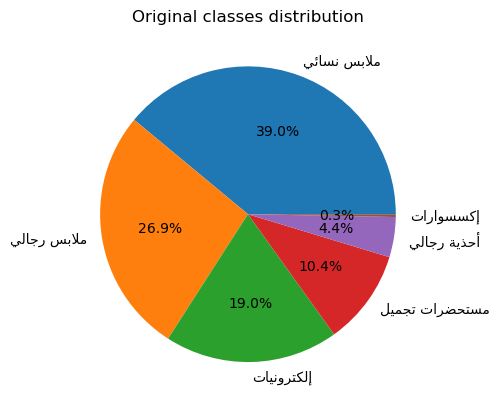

In [9]:
# استيراد مكتبة matplotlib لرسم البيانات
import matplotlib.pyplot as plt

# استخراج أسماء الفئات من عمود 'term_name' في DataFrame df
y_labels = df['term_name']

# استيراد مكتبتين لمعالجة النصوص العربية
import arabic_reshaper
from bidi.algorithm import get_display

# حساب عدد القيم الفريدة في y_labels
count_values = y_labels.value_counts()

# الحصول على أسماء الفئات كقائمة
labels = count_values.index.to_list()
labels_A = []  # قائمة جديدة لتخزين الأسماء المعالجة

# معالجة الأسماء العربية لتظهر بشكل صحيح في الرسم
for item in labels:
    # إعادة تشكيل النص العربي ليظهر بشكل صحيح
    reshaped_item = arabic_reshaper.reshape(item)
    # استخدام مكتبة bidi لجعل النص يظهر من اليمين لليسار
    labels_A.append(get_display(reshaped_item))

# تعيين عنوان الرسم البياني
plt.title('Original classes distribution')

# رسم مخطط دائري يوضح توزيع الفئات
plt.pie(x=count_values, labels=labels_A, autopct='%1.1f%%')

# عرض الرسم البياني
plt.show()

In [10]:
# استيراد Counter من مكتبة collections لحساب تكرار العناصر
from collections import Counter

# إنشاء كائن Counter لحساب تكرار القيم في المتغير التابع y
counter = Counter(y)

# حلقة لتكرار العناصر في Counter
for k, v in counter.items():
    # حساب النسبة المئوية لكل فئة
    per = v / len(y) * 100
    # طباعة الفئة، عددها، ونسبتها المئوية
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=75, n=382 (38.980%)
Class=78, n=186 (18.980%)
Class=74, n=264 (26.939%)
Class=79, n=102 (10.408%)
Class=76, n=43 (4.388%)
Class=82, n=3 (0.306%)


In [11]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [12]:
# استيراد RandomOverSampler من مكتبة imblearn.over_sampling
from imblearn.over_sampling import RandomOverSampler

# إنشاء كائن RandomOverSampler
oversample = RandomOverSampler()

# تطبيق تقنية زيادة العينات على البيانات
# يتم استخدام fit_resample لتعديل X و y بحيث تكون الفئات متوازنة
X, y = oversample.fit_resample(X, y)

In [13]:
# استيراد Counter من مكتبة collections لحساب تكرار العناصر
from collections import Counter

# إنشاء كائن Counter لحساب تكرار القيم في المتغير التابع y
counter = Counter(y)

# حلقة لتكرار العناصر في Counter
for k, v in counter.items():
    # حساب النسبة المئوية لكل فئة
    per = v / len(y) * 100
    # طباعة الفئة، عددها، ونسبتها المئوية
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=75, n=382 (16.667%)
Class=78, n=382 (16.667%)
Class=74, n=382 (16.667%)
Class=79, n=382 (16.667%)
Class=76, n=382 (16.667%)
Class=82, n=382 (16.667%)


In [14]:
# استيراد الدوال اللازمة من مكتبات sklearn
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier

# إنشاء نماذج من خوارزميات التصنيف المختلفة
model_DecisionTreeClassifier = DecisionTreeClassifier()  # نموذج شجرة القرار
model_CategoricalNB = CategoricalNB()  # نموذج نايف بايز للفئات
model_KNeighborsClassifier = KNeighborsClassifier()  # نموذج الجيران الأقرب

# تقييم نموذج شجرة القرار باستخدام التحقق المتقاطع (cross-validation)
score_accuracy = cross_val_score(model_DecisionTreeClassifier, X, y, cv=10, scoring='accuracy')
meanScore = score_accuracy.mean()  # حساب متوسط الدقة
print("Accuracy DecisionTreeClassifier= ", round(meanScore * 100, 2))  # طباعة الدقة كنسبة مئوية

# تقييم نموذج نايف بايز للفئات باستخدام التحقق المتقاطع
score_accuracy = cross_val_score(model_CategoricalNB, X, y, cv=10, scoring='accuracy')
meanScore = score_accuracy.mean()  # حساب متوسط الدقة
print("Accuracy model_CategoricalNB= ", round(meanScore * 100, 2))  # طباعة الدقة كنسبة مئوية

# تقييم نموذج الجيران الأقرب باستخدام التحقق المتقاطع
score_accuracy = cross_val_score(model_KNeighborsClassifier, X, y, cv=10, scoring='accuracy')
meanScore = score_accuracy.mean()  # حساب متوسط الدقة
print("Accuracy model_KNeighborsClassifier= ", round(meanScore * 100, 2))  # طباعة الدقة كنسبة مئوية

Accuracy DecisionTreeClassifier=  82.86
Accuracy model_CategoricalNB=  72.12
Accuracy model_KNeighborsClassifier=  68.29


In [15]:
# إنشاء نموذج شجرة القرار
model = DecisionTreeClassifier()

# تدريب النموذج باستخدام البيانات
model.fit(X.values, y)

DecisionTreeClassifier()

In [16]:
# تعريف القيم المدخلة للتنبؤ
country = 2  # قيمة الدولة (ممثلة كعدد)
age = 22     # العمر
gender = 0   # قيمة الجنس (ممثلة كعدد)

# إنشاء قائمة تحتوي على القيم المدخلة
example = [[country, age, gender]]

# استخدام النموذج للتنبؤ باحتمالات الفئات
pred_proba = model.predict_proba(example)
print(pred_proba)  # طباعة احتمالات الفئات

# استخدام النموذج للتنبؤ بالفئة الأكثر احتمالاً
pred_class = model.predict(example)
print(pred_class)  # طباعة الفئة المتوقعة

[[0.47058824 0.         0.52941176 0.         0.         0.        ]]
[76]


In [17]:
# استيراد مكتبة pickle لحفظ وتحميل النماذج
import pickle

# تحديد اسم الملف الذي سيتم حفظ النموذج فيه
fillname = 'classification_model'

# حفظ النموذج باستخدام pickle
# 'wb' تعني فتح الملف في وضع الكتابة الثنائية
pickle.dump(model, open(fillname, 'wb'))

In [18]:
# تحميل النموذج المحفوظ باستخدام pickle
loaded_model = pickle.load(open(fillname, 'rb'))

# استخدام النموذج المحمّل للتنبؤ بالفئة للمدخلات المعطاة
results = loaded_model.predict(example)

# طباعة الفئة المتوقعة
print(results[0])

76


In [19]:
def get_category_code(filename, country, age, gender):
    # استيراد مكتبة pickle لتحميل النموذج
    import pickle

    # تحميل النموذج المحفوظ باستخدام pickle
    loaded_model = pickle.load(open(filename, 'rb'))

    # إنشاء قائمة تحتوي على القيم المدخلة للتنبؤ
    example = [[country, age, gender]]

    # استخدام النموذج المحمّل للتنبؤ بالفئة للمدخلات المعطاة
    results = loaded_model.predict(example)

    # إرجاع الفئة المتوقعة
    return results[0]

In [20]:
get_category_code('classification_model',1 , 22, 1)

74

In [21]:
pip install m2cgen

Note: you may need to restart the kernel to use updated packages.


In [22]:
# استيراد مكتبة m2cgen لتحويل النماذج إلى كود بلغة PHP
import m2cgen as m2c

# تحويل النموذج المدرب إلى كود PHP
model_php = m2c.export_to_php(model)

# فتح ملف جديد لكتابة كود PHP
f = open("predict_category_php.php", 'w')  # تأكد من إضافة .php لامتداد الملف

# كتابة كود PHP في الملف
f.write(model_php)

# إغلاق الملف
f.close()

In [23]:
# إنشاء كائن cursor مع تمكين استخدام القواميس (dictionary) للحصول على نتائج الاستعلام
cursor = connection_mydb.cursor(dictionary=True)

# حذف الجدول إذا كان موجودًا مسبقًا
sql = "DROP TABLE IF EXISTS custom_country_codes"
cursor.execute(sql)

# إنشاء جدول جديد باسم custom_country_codes
sql = '''
        CREATE TABLE custom_country_codes (
        ID int(11) NOT NULL AUTO_INCREMENT,
        code int(11) NOT NULL,
        country char(2) NOT NULL,
        PRIMARY KEY (ID)
        ) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
      '''
cursor.execute(sql)  # تنفيذ استعلام إنشاء الجدول
connection_mydb.commit()  # تأكيد التغييرات في قاعدة البيانات

# إدخال البيانات في الجدول
for country in le_country.classes_:
    code = le_country.transform([country])[0]
    code = code.item()  # <-- التعديل هنا باستخدام .item()
    print(type(code)) #للتأكد من نوعه
    sql = "INSERT INTO custom_country_codes (code, country) VALUES (%s, %s)"
    val = (code, country)
    cursor.execute(sql, val)
    connection_mydb.commit()

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [29]:
cursor = connection_mydb.cursor(dictionary=True)
sql = '''DROP TABLE IF EXISTS custom_gender_codes'''
cursor.execute(sql)

sql = '''
        CREATE TABLE custom_gender_codes (
        ID int(11) NOT NULL AUTO_INCREMENT,
        code int(11) NOT NULL,
        gender char(10) NOT NULL, PRIMARY KEY (ID))ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
      '''
cursor.execute(sql)
connection_mydb.commit()

for gender in le_gender.classes_:
    code=le_gender.transform([gender])[0]
    code = code.item()
    print(type(code))
    sql = "INSERT INTO custom_gender_codes (code, gender) VALUES (%s, %s)"
    val = (code, gender)
    cursor.execute(sql, val)
    connection_mydb.commit()

<class 'int'>
<class 'int'>


In [44]:
def category_best_seller_products(category_id, n=3):
    # إنشاء كائن cursor مع تمكين استخدام القواميس (dictionary) للحصول على نتائج الاستعلام
    cursor = connection_mydb.cursor(dictionary=True)

    # استعلام SQL لاختيار أفضل المنتجات مبيعًا في فئة معينة
    sql = '''SELECT wp_term_taxonomy.term_id,
                  wp_wc_order_product_lookup.product_id,  
                  sum(wp_wc_order_product_lookup.product_qty) as sumsales
              FROM wp_wc_order_product_lookup 
              INNER JOIN wp_term_relationships ON wp_term_relationships.object_id = wp_wc_order_product_lookup.product_id
              INNER JOIN wp_term_taxonomy ON wp_term_relationships.term_taxonomy_id = wp_term_taxonomy.term_taxonomy_id
              WHERE wp_term_taxonomy.taxonomy = 'product_cat' AND 
                    wp_term_taxonomy.term_id = (%s)
              GROUP BY wp_term_taxonomy.term_id, wp_wc_order_product_lookup.product_id
              ORDER BY sumsales DESC
          '''

    # إعداد المعاملات للاستعلام
    param = (category_id, )
    
    # تنفيذ الاستعلام مع المعاملات
    cursor.execute(sql, param)
    
    # جلب جميع النتائج
    results = cursor.fetchall()
    
    # قائمة لتخزين معرفات المنتجات الأفضل مبيعًا
    products_ids = []
    
    # التحقق من وجود نتائج
    if results is not None:
        i = 0
        # الحصول على أول n منتج مبيع
        while i < n and i < len(results):
            product_id = results[i]['product_id']  # الحصول على معرف المنتج
            products_ids.append(product_id)  # إضافته إلى القائمة
            i += 1  # زيادة العداد
            
    return products_ids  # إرجاع قائمة معرفات المنتجات

In [45]:
category_best_seller_products(78, 3)

[56238, 56217, 56193]

In [46]:
def get_product_name(product_id):
    # إنشاء كائن cursor مع تمكين استخدام القواميس (dictionary) للحصول على نتائج الاستعلام
    cursor = connection_mydb.cursor(dictionary=True)
    
    # استعلام SQL لاختيار عنوان المنتج بناءً على معرف المنتج
    sql = "SELECT post_title FROM wp_posts WHERE ID = (%s)"
    id = (product_id,)  # إعداد المعاملات للاستعلام
    
    # تنفيذ الاستعلام مع المعاملات
    cursor.execute(sql, id)
    
    # جلب جميع النتائج
    results = cursor.fetchall()
    
    # التحقق من وجود نتائج
    if len(results) > 0:
        return results[0]['post_title']  # إرجاع عنوان المنتج إذا وُجد
    
    return "Unknown Product"  # إرجاع "Unknown Product" إذا لم توجد نتائج

In [47]:
def get_gender_code(gender):
    # إنشاء كائن cursor مع تمكين استخدام القواميس (dictionary) للحصول على نتائج الاستعلام
    cursor = connection_mydb.cursor(dictionary=True)
    
    # استعلام SQL لاختيار الكود بناءً على الجنس
    sql = "SELECT code FROM custom_gender_codes WHERE gender = (%s)"
    param = (gender, )  # إعداد المعاملات للاستعلام
    
    # تنفيذ الاستعلام مع المعاملات
    cursor.execute(sql, param)
    
    # جلب جميع النتائج
    result = cursor.fetchall()
    
    # التحقق من وجود نتائج
    if result is not None and len(result) > 0:
        return result[0]['code']  # إرجاع الكود إذا وُجد
    else:
        return 0  # إرجاع 0 إذا لم توجد نتائج

In [49]:
def get_country_code(country):
    # إنشاء كائن cursor مع تمكين استخدام القواميس (dictionary) للحصول على نتائج الاستعلام
    cursor = connection_mydb.cursor(dictionary=True)
    
    # استعلام SQL لاختيار الكود بناءً على اسم الدولة
    sql = "SELECT code FROM custom_country_codes WHERE country = (%s)"
    param = (country, )  # إعداد المعاملات للاستعلام
    
    # تنفيذ الاستعلام مع المعاملات
    cursor.execute(sql, param)
    
    # جلب جميع النتائج
    result = cursor.fetchall()
    
    # التحقق من وجود نتائج
    if result is not None and len(result) > 0:
        return result[0]['code']  # إرجاع الكود إذا وُجد
    else:
        return 0  # إرجاع 0 إذا لم توجد نتائج

In [50]:
def get_customer_products(customer_id, n=3):
    # إنشاء كائن cursor مع تمكين استخدام القواميس (dictionary) للحصول على نتائج الاستعلام
    cursor = connection_mydb.cursor(dictionary=True)
    user_id = 0  # تهيئة user_id

    # استعلام SQL للحصول على user_id بناءً على customer_id
    sql = "SELECT user_id FROM wp_wc_customer_lookup WHERE customer_id = (%s)"
    param = (customer_id, )
    cursor.execute(sql, param)
    result = cursor.fetchall()
    
    # التحقق من وجود نتيجة وتعيين user_id
    if result is not None and len(result) > 0:
        user_id = result[0]['user_id']  

    country = ""
    # استعلام SQL للحصول على country من wp_usermeta
    sql = "SELECT meta_value FROM wp_usermeta WHERE user_id = (%s) AND meta_key = 'country'"
    param = (user_id, )
    cursor.execute(sql, param)
    result = cursor.fetchall()
    
    # التحقق من وجود نتيجة وتعيين country
    if result is not None and len(result) > 0:
        country = result[0]['meta_value']
    
    # الحصول على كود الدولة
    country_code = get_country_code(country)

    age = 0
    # استعلام SQL للحصول على age من wp_usermeta
    sql = "SELECT meta_value FROM wp_usermeta WHERE user_id = (%s) AND meta_key = 'age'"
    param = (user_id, )
    cursor.execute(sql, param)
    result = cursor.fetchall()
    
    # التحقق من وجود نتيجة وتعيين age
    if result is not None and len(result) > 0:
        age = int(result[0]['meta_value'])

    gender = ""
    # استعلام SQL للحصول على gender من wp_usermeta
    sql = "SELECT meta_value FROM wp_usermeta WHERE user_id = (%s) AND meta_key = 'gender'"
    param = (user_id, )
    cursor.execute(sql, param)
    result = cursor.fetchall()
    
    # التحقق من وجود نتيجة وتعيين gender
    if result is not None and len(result) > 0:
        gender = result[0]['meta_value']
        
    # الحصول على كود الجنس
    gender_code = get_gender_code(gender)
    
    # الحصول على كود الفئة بناءً على country_code، age، و gender_code
    category_code = get_category_code('classification_model', country_code, age, gender_code)
    
    # الحصول على معرفات المنتجات الأفضل مبيعًا في الفئة المحددة
    products_ids = category_best_seller_products(int(category_code), n)
    
    products = []
    # الحصول على أسماء المنتجات بناءً على معرفاتها
    for id in products_ids:
        product = get_product_name(id)
        products.append(product)
    
    return products  # إرجاع قائمة المنتجات

In [51]:
get_customer_products(1)

['بنطال قماش رجالي-أسود داكن-ZARA',
 "بنطال قماش رجالي-أزرق-Levi's",
 'بنطال قماش رجالي-أسود داكن-Cartier']